In [4]:
import geokit as gk
import countrydata
from copy import copy
import math

In [2]:
output_folder = "/storage/internal/home/c-winkler/Research/02_Projects/02_WASCAL_graduate_school/data/01_LEA_data/00_exclusion_datasets/CGLS"
output_folder = "/storage/internal/home/c-winkler/Research/02_Projects/02_WASCAL_graduate_school/data/01_LEA_data/00_exclusion_datasets/GLWD"

In [10]:
base_raster="/storage/internal/data/c-winkler/04_Data/01_Geodata/Landcover/Copernicus_CGLS_LC100m_V3.0/2019/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif"
base_raster="/storage/internal/data/c-winkler/04_Data/01_Geodata/WaterCourses/GLWD_GlobalLakesAndWetlandsDatabase/GLWD-level3/glwd_3/GLWD.tif"

In [13]:
# extract raster info and base matrix (full data matrix)
raster_info=gk.raster.rasterInfo(base_raster)
base_mx = gk.raster.extractMatrix(base_raster)
base_shape = base_mx.shape

In [14]:
# load all country shapes
gid_shp="/storage/internal/data/gears/lecture_heidi_niger/data/00_general_data/00_geospatial_data/GADM_country_shapes/gadm36_0.shp"

countries = countrydata.Political.get_union('ECOWAS')

countries_str="','".join(countries)
country_df=gk.vector.extractFeatures(
    source=gid_shp,
    where=f"GID_0 in ('{countries_str}')"
)
country_df

,geom,GID_0,NAME_0
0,"MULTIPOLYGON (((1.94152796 6.30013895,1.941527...",BEN,Benin
1,"POLYGON ((0.76395154 10.99730682,0.75827003 10...",BFA,Burkina Faso
2,"MULTIPOLYGON (((-6.66930389 4.72958422,-6.6693...",CIV,Côte d'Ivoire
3,"MULTIPOLYGON (((-24.68680573 14.81264019,-24.6...",CPV,Cape Verde
4,"MULTIPOLYGON (((-2.03541589 4.75180483,-2.0354...",GHA,Ghana
5,"MULTIPOLYGON (((-13.79485989 9.46847153,-13.79...",GIN,Guinea
6,"MULTIPOLYGON (((-16.8148613 13.38819313,-16.81...",GMB,Gambia
7,"MULTIPOLYGON (((-15.72069263 10.87430668,-15.7...",GNB,Guinea-Bissau
8,"MULTIPOLYGON (((-10.81263924 6.34902811,-10.81...",LBR,Liberia
9,"POLYGON ((-3.43877888 13.16110611,-3.448838 13...",MLI,Mali


In [15]:
for country in countries:
    print("Now process", country)
    # extract and calculate country data
    country_shape = country_df[country_df.GID_0==country].geom.iloc[0]
    # calculate the "cell number extent" of the country shape when applied to the raster resolution and bounds
    edge_cell_numbers={
        'left': math.floor((country_shape.GetEnvelope()[0]-raster_info.bounds[0])/raster_info.pixelWidth),
        'right': math.ceil((country_shape.GetEnvelope()[1]-raster_info.bounds[0])/raster_info.pixelWidth),
        'bottom': base_shape[0] - math.floor((country_shape.GetEnvelope()[2]-raster_info.bounds[1])/raster_info.pixelHeight),
        'top': base_shape[0] - math.ceil((country_shape.GetEnvelope()[3]-raster_info.bounds[1])/raster_info.pixelHeight),
    }
    # extract the country shape matrix based on the cell number slices
    mx = copy(base_mx[edge_cell_numbers['top']:edge_cell_numbers['bottom'], edge_cell_numbers['left']:edge_cell_numbers['right']])
    # create the folder path
    os.mkdir(os.path.join(output_folder, country))
    # generate the new bounds, in line with original raster bounds and resolution
    bounds=(
        raster_info.bounds[0]+edge_cell_numbers['left']*raster_info.pixelWidth,
        raster_info.bounds[3]-edge_cell_numbers['bottom']*raster_info.pixelHeight,
        raster_info.bounds[0]+edge_cell_numbers['right']*raster_info.pixelWidth,
        raster_info.bounds[3]-edge_cell_numbers['top']*raster_info.pixelHeight,
    )
    # generate the raster while saving to disk
    rstr = gk.raster.createRaster(
        data=mx,
        bounds=bounds,
        output=os.path.join(
            output_folder,
            country,
            f'{country}_warped_{os.path.basename(base_raster)}',
        ),
        pixelWidth=raster_info.pixelWidth,
        pixelHeight=raster_info.pixelHeight,
        srs=raster_info.srs,
        noData=raster_info.noData,
        meta=({'warping_info':'Warped to new bounds with unchanged parameters, based on raw data (see other keys'} | raster_info.meta),
    )

Now process BEN
Now process BFA
Now process CIV
Now process CPV
Now process GHA
Now process GIN
Now process GMB
Now process GNB
Now process LBR
Now process MLI
Now process NER
Now process NGA
Now process SEN
Now process SLE
Now process TGO


ERROR 1: /storage/internal/home/c-winkler/Research/02_Projects/02_WASCAL_graduate_school/data/01_LEA_data/00_exclusion_datasets/GLWD/CPV/CPV_warped_GLWD.tif, band 1: Failed to compute min/max, no valid pixels found in sampling.


AxHands(ax=<Axes:>, handles=<matplotlib.image.AxesImage object at 0x7f172fd021d0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f172fd02500>)

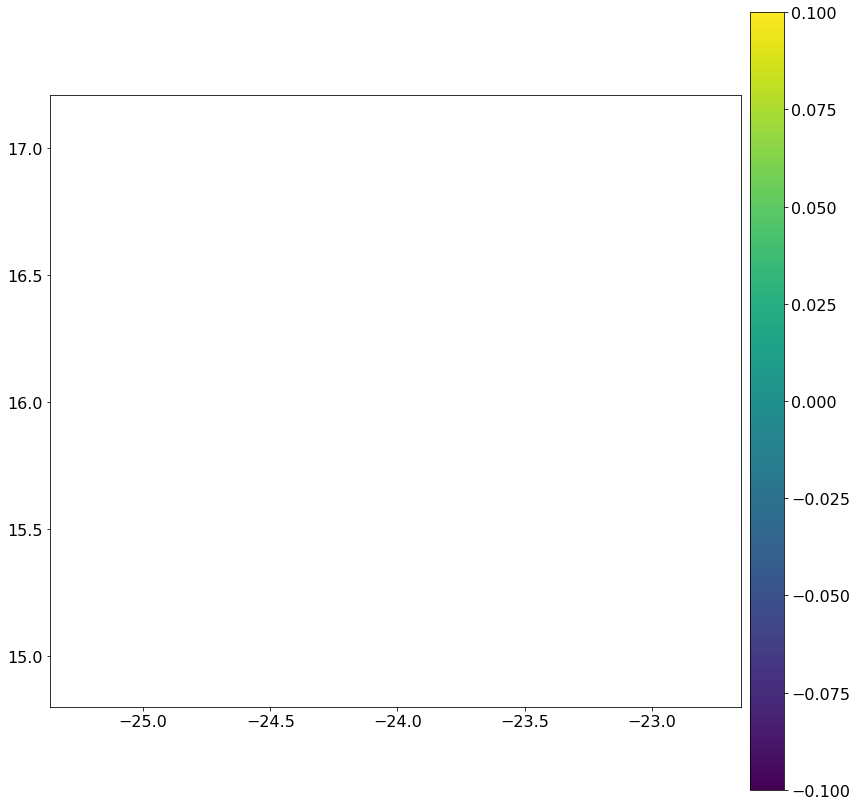

In [16]:
gk.drawRaster("/storage/internal/home/c-winkler/Research/02_Projects/02_WASCAL_graduate_school/data/01_LEA_data/00_exclusion_datasets/GLWD/CPV/CPV_warped_GLWD.tif")

In [ ]:
# # THIS IS A DRAFT FOR A GEOKIT FUNCTION

# def extract_subset(source, geom, output=None, meta=None):
    # """
    # Extracts an unchanged subset of a raster over a geometry, with zero shift or resolution change.
    # Note: All cells touching the geom will be extracted, touching geoms will hence produce rasters with slight overlaps.
    
#     source: str or numpy.ndarray or GDAL RASTERDATASET?? #TODO
#     """
#     if isinstance(source, str):
#         assert os.path.isfile(str), f"If source is passed as a str, it must point to an existing raster file."
#         raster_info = gk.raster.rasterInfo(source)
#         source = gk.raster.extractMatrix(source)
#     elif isinstance(source, np.ndarray): 
#         assert isinstance(meta, dict), f"If source is passed as a pre-loaded matrix, 'meta' data must be provided as a dictionary"
#         required_keys=['bounds', 'pixelWidth', 'pixelHeight', 'srs', 'noData']
#         assert all(x in meta.keys() for x in required_keys), f"If metadata is passed as a dict, it must contain: {', '.join(required_keys)}"
#         raster_info = meta
#     else:
#         assert isinstance(source, raster), f"If the source argument is not a str or a numpy array, it must be a GDAL RASTERDATASET??" #TODO
#         raster_info = gk.raster.rasterInfo(source)
    
#     assert isinstance(geom, osgeo.ogr.Geometry), f"'geom' must be an instance of osgeo.ogr.Geometry."

#     # calculate the "cell number extent" of the country shape when applied to the raster resolution and bounds
#     edge_cell_numbers={
#         'left': math.floor((geom.GetEnvelope()[0]-raster_info.bounds[0])/raster_info.pixelWidth),
#         'right': math.ceil((geom.GetEnvelope()[1]-raster_info.bounds[0])/raster_info.pixelWidth),
#         'bottom': base_shape[0] - math.floor((geom.GetEnvelope()[2]-raster_info.bounds[1])/raster_info.pixelHeight),
#         'top': base_shape[0] - math.ceil((geom.GetEnvelope()[3]-raster_info.bounds[1])/raster_info.pixelHeight),
#     }
    
#     # extract the country shape matrix based on the cell number slices
#     mx = copy(base_mx[edge_cell_numbers['top']:edge_cell_numbers['bottom'], edge_cell_numbers['left']:edge_cell_numbers['right']])
    
#     # generate the new bounds, in line with original raster bounds and resolution
#     bounds=(
#         raster_info.bounds[0]+edge_cell_numbers['left']*raster_info.pixelWidth,
#         raster_info.bounds[3]-edge_cell_numbers['bottom']*raster_info.pixelHeight,
#         raster_info.bounds[0]+edge_cell_numbers['right']*raster_info.pixelWidth,
#         raster_info.bounds[3]-edge_cell_numbers['top']*raster_info.pixelHeight,
#     )

#     # generate and return the raster while saving to disk
#     return gk.raster.createRaster(
#         data=mx,
#         bounds=bounds,
#         output=os.path.join(
#             output_folder,
#             country,
#             f'{country}_warped_{os.path.basename(base_raster)}',
#         ),
#         pixelWidth=raster_info.pixelWidth,
#         pixelHeight=raster_info.pixelHeight,
#         srs=raster_info.srs,
#         noData=raster_info.noData,
#         meta=({'warping_info':'Subset with new bounds with unchanged parameters, based on raw data (see other keys)'} | raster_info.meta),
#     )